# Experiments carried out applying the RR dRR intervals method

In [3]:
# Load NeuroKit and other useful packages
import neurokit2 as nk #TODO look into this algorithm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
from tqdm import tqdm

#### Function to bin RR dRR points into grids

In [4]:
def assign_to_grid(points, plotting=False):
    """
    Function which calculates the population of points in each grid section, and 
    can plot these as saturation of colours in the grid. 
    """
    # find sum of no_points in each grid section 
    grid_count = np.zeros((RR_dimensions, dRR_dimensions))
    
    for n_,point in enumerate(points):

        RR_val = point[0]
        dRR_val = point[1]

        for i in range(RR_dimensions-1): # scanning RR direction 
            if RR_val > RR_points[i] and RR_val <= RR_points[i+1]:
                for j in range(dRR_dimensions-1): # scanning dRR direction
                    if dRR_val > dRR_points[j] and dRR_val <= dRR_points[j+1]:
                        grid_count[i,j] += 1

                        # colour in the grid_sections with intensity of colour corresponding to the count of points in that section 
                        if plotting:
                            plt.fill_between(RR_points, [dRR_points[j+1]]*RR_dimensions, [dRR_points[j]]*RR_dimensions, 
                                             where=[(RR_point == RR_points[i]) or (RR_point == RR_points[i+1]) for RR_point in RR_points],
                                             alpha = 5/len(points), color='b')

    return grid_count


#### Draw the grid 

In [7]:
show_ecg = False
plot_grid = False

### Genereate the grid, range values should be universally applicable although this will need to be tested across different dataset
# TODO check these ranges
RR_range = (0, 500)
dRR_range = (-300, 300)
RR_dimensions = int(RR_range[1] - RR_range[0]/25)
square_length = int((RR_range[1] - RR_range[0]) / RR_dimensions)
dRR_dimensions = int((dRR_range[1] - dRR_range[0]) / square_length)
RR_points = np.linspace(RR_range[0],RR_range[1], RR_dimensions)
dRR_points = np.linspace(dRR_range[0],dRR_range[1],dRR_dimensions)
if plot_grid:
    plt.vlines(RR_points, dRR_range[0], dRR_range[1])
    plt.hlines(dRR_points, RR_range[0], RR_range[1])
grid_points = np.meshgrid(RR_points, dRR_points)

#### Generate grid count data for dataset provided

In [38]:
def generate_grid_count_data_for_dataset(path_to_dataset, grid_counting_data={}):
    """
    For each ECG in the dataset provided, calculate the count of each grid section of 
    number of RR dRR points found from the ECG in that grid section
    """
    
    filenames = [file.split(".mat",2)[0] for file in os.listdir(path_to_dataset) if file.endswith(".mat")]
    
    try:
        for filename in tqdm([filename for filename in filenames if filename not in list(grid_counting_data.keys())]):

            # Retrieve ECG data from data folder (sampling rate= 1000 Hz)
            ecg_signal = scipy.io.loadmat(f"{path_to_dataset}\\{filename}.mat")['val'][0]
            ecg_signal = ecg_signal / np.max(ecg_signal) # normalise

            # Extract R-peaks locations
            try:
                _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=300)
            except IndexError:
                print(f"unable to find peaks in file {filename}")
                continue

            # Calculate the RR and dRR values
            R_peaks = rpeaks['ECG_R_Peaks']
            RR = (np.pad(R_peaks, (0,1))[1:] - R_peaks)[:-1]
            dRR = (np.pad(RR, (0,1))[1:] - RR)[:-1]
            RR = RR[1:]

            points = list(zip(RR,dRR))

            if show_ecg: # Visualize R-peaks in ECG signal
                plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)

            if plot_grid:
                digit = str(i).zfill(5)
                plt.scatter(RR,dRR, label=f'A{digit}')
                plt.xlabel('RR')
                plt.ylabel('dRR')
                plt.legend()
                plt.xlim(50,450)
                plt.ylim(-250,250)
                plt.show()

            grid_count = assign_to_grid(points, plotting=plot_grid)
            proportion_grid_sections_non_zero_count = np.nonzero(grid_count)[0].shape[0]/grid_count.size

            grid_counting_data[filename] = proportion_grid_sections_non_zero_count

        return grid_counting_data
    
    except KeyboardInterrupt:
        return grid_counting_data

In [ ]:
%store -r grid_counting_data

In [37]:
path_to_2017_dataset = "2_data\\physionet_datasets\\training2017\\"
grid_counting_data = generate_grid_count_data_for_dataset(path_to_dataset=path_to_2017_dataset, grid_counting_data=grid_counting_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]

unable to find peaks in file A07983


### Visualise the sample which failed in R detection

In [40]:
import wfdb

def show_sample_ecg(path_to_sample):
    sample_to_visualise = path_to_sample.split("\\")[-1].split('.mat',2)[0] 
    record = wfdb.rdrecord(path_to_sample.split('.mat',2)[0], channels=[0])
    wfdb.plot_wfdb(record=record, plot_sym=True, time_units='seconds')

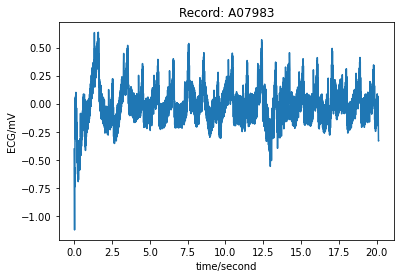

In [41]:
show_sample_ecg("2_data\\physionet_datasets\\training2017\\A07983.mat") 

### TODO


Thresholding, check threshold values, maybe optimise (therefore training).

Get reuslt on 2017

regression maybe,

Apply to 2020 (specifically the holter dataset not 

# Results of grid count

In [43]:
labels_df = pd.read_csv("2_data\\physionet_datasets\\training2017\\REFERENCE.csv", names=["filename","label"])

## Plot all data from grid_counting_data to see if thresholding will work



#### Prepare data and labels/colours etc for plots

In [59]:
def get_label(filename):
    return labels_df[labels_df["filename"] == filename].label.item()
    
# sorted_data = {k: v for k, v in sorted(grid_counting_data.items(), key=lambda item: item[1])}
labels = {filename: get_label(filename) for filename in grid_counting_data.keys()}

In [60]:
colour_key = {"N": "g", "O": "b", "A": "r", "~": "grey"}
size_key = {"N": 5, "O": 5, "A": 5, "~": 5}

In [61]:
average_values_for_each_category = [np.mean(np.array([grid_counting_data[filename] for filename in labels.keys() if labels[filename] == label])) for label in colour_key.keys()]
average_values_for_each_category = dict(zip(colour_key.keys(),average_values_for_each_category))

#### Function for plotting the grid count data 

In [57]:
from matplotlib.lines import Line2D

In [62]:
def plot_grid_count_data_and_averages(grid_counting_data, colour_key, size_key, average_values_for_each_category):
    
    # plot format stuff
    plt.rcParams["figure.figsize"] = (20,6)
    plt.rcParams['figure.dpi'] = 300

    # find data and visual metadata for plotting
    x = np.arange(len(grid_counting_data))
    y = list(grid_counting_data.values())
    colours = [colour_key[labels[filename]] for filename in grid_counting_data.keys()]
    sizes = [size_key[labels[filename]] for filename in grid_counting_data.keys()]
    
    # plot and produce legend and axes labels
    plt.scatter(x, y, s=sizes, c=colours)
    plt.xlabel("sample")
    plt.ylabel("proportion of grids populated")
    plt.title("Scatter plot of 2017 dataset values from grid counting method, colour coded with labels, mean values plotted")

    custom_lines = [Line2D([0], [0], color=colour_, lw=4) for colour_ in colour_key.values()]
    plt.legend(custom_lines, [key for key in colour_key.keys()])
    
    # plot average values
    for label, average_value in average_values_for_each_category.items():
        plt.hlines(average_value, 0, len(grid_counting_data), color=colour_key[label], linewidths=5)

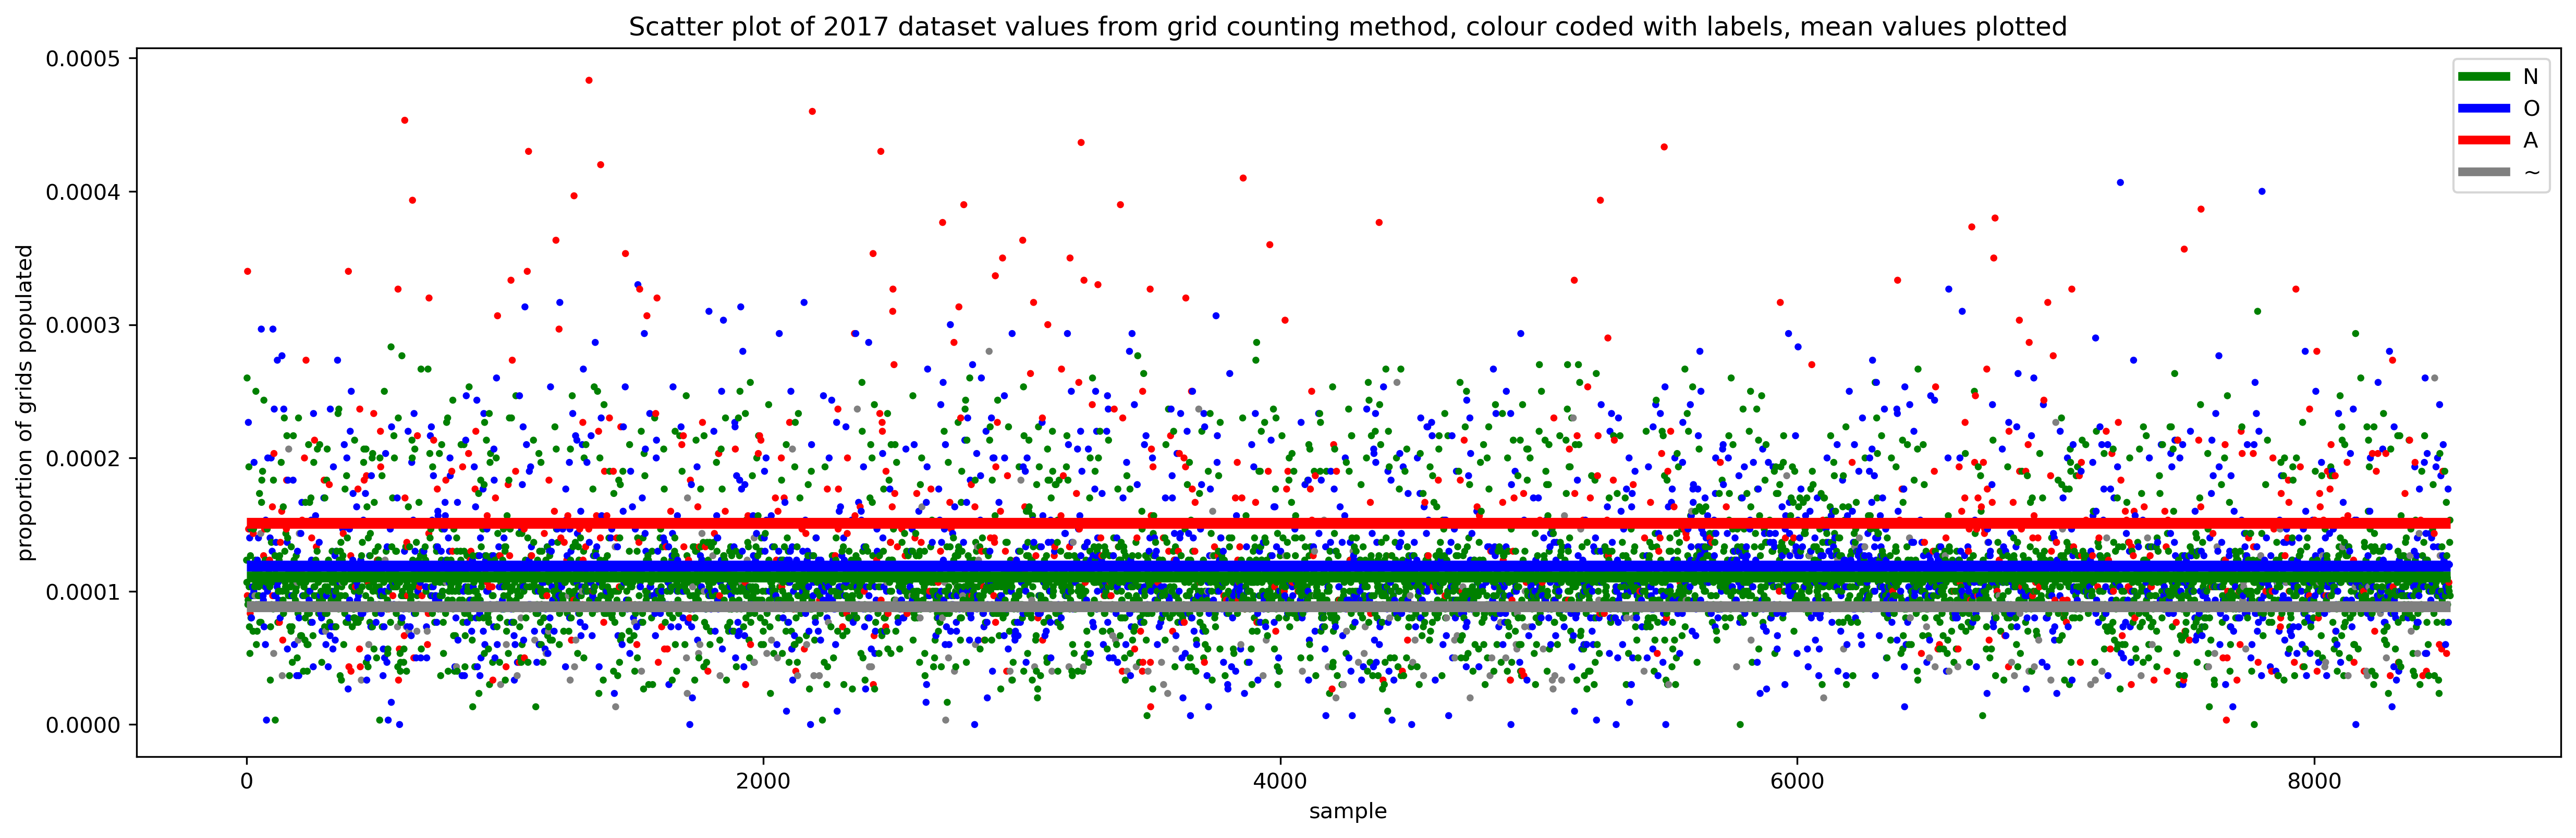

In [63]:
plot_grid_count_data_and_averages(grid_counting_data, colour_key, size_key, average_values_for_each_category)

## Optimising threshold value

In order to train this method, optimising the threshold value which is the value at which if the proportion of grids populated is above, the sample is labelled as 'A', whereas if it is below it is labelled as 'Non A' 

#### Prepare the data for training

In [66]:
# remove noisy samples 
grid_count_data_dict = {k: v for k,v in grid_counting_data.items() if labels[k] != "~"}

In [67]:
# reformat the labels to just binary classification of either AF or not AF
def binary_classification_converter(label):
    if label == 'A': # AF
        return 'A'
    else: # not AF
        return 'N'

label_data_binary_classification = {k: binary_classification_converter(label) for k,label in labels.items() if label != "~"}

#### Define the function to call the threshold method

In [161]:
def produce_predictions_based_on_threshold(proposal_threshold, **kwargs):
    """
    Function to produce predictions array for supplied data by simply 
    predicting that any ECG with grid count proportion above the 
    provided threshold is AF, or below threshold is Non AF
    """
    
    
    # produce array of all x values
    arr_grid_count_data = np.array(list(kwargs["grid_count_data_dict"].items()), dtype=object)
    
    # find indices of ECGs which should be diagnosed as AF or non AF 
    indices_AF = np.where(arr_grid_count_data.T[1] >= proposal_threshold)[0]
    indices_non_AF = np.delete(np.arange(arr_grid_count_data.shape[0]), indices_AF)
    
    # produce predictions array
    predictions = np.zeros((arr_grid_count_data.shape), dtype=object)
    predictions[:,0] = arr_grid_count_data[:,0]
    predictions[indices_AF,1] = "A"
    predictions[indices_non_AF,1] = "N"
    
    return predictions

### Design a cost function for training the threshold value

In [176]:
def cost_function(w, **kwargs):
    """
    Cost function for training the model, which is simply a weighted sum 
    of incorrect labels, with more weight given to false negatives than 
    false positives, to prevent model just fitting very well to predicting 
    Non AF, which will most often be correct because the dataset is heavily 
    skewed towards Non AF.
    """
    
    predictions = kwargs["model_call_function"](w, **kwargs)    
    cost = 0
    
    for filename, prediction in predictions:
        # print(round(grid_proportion_value, 5), proposal_threshold, prediction, label_data_dict[filename])
        ground_truth_label = kwargs["label_data_dict"][filename]
        if prediction != ground_truth_label:
            if prediction == 'A' and ground_truth_label == 'N': # false positive AF diagnosis
                cost += 1
            elif prediction == 'N' and ground_truth_label == 'A': #  false negative AF diagnosis
                cost += 5
    
    return cost

In [178]:
kwargs = {"model_call_function": produce_predictions_based_on_threshold, 
          "grid_count_data_dict": grid_count_data_dict, 
          "label_data_dict": label_data_binary_classification}

cost_function(0.0001, **kwargs)

5566

initially a cost function which gave equal weighting to type I and type II error was used, but this led to higher threshold value because cost of having this higher value and missing some AF labels was minimal, because they are a lot less frequent in the dataset anyway.

### TODO 

experiment with this cost fucntion 
experiment with changing dataset for better representation of AF 

### Plot the cost function over different threshold values

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.84it/s]


(0.00015556761439304722, 3238)

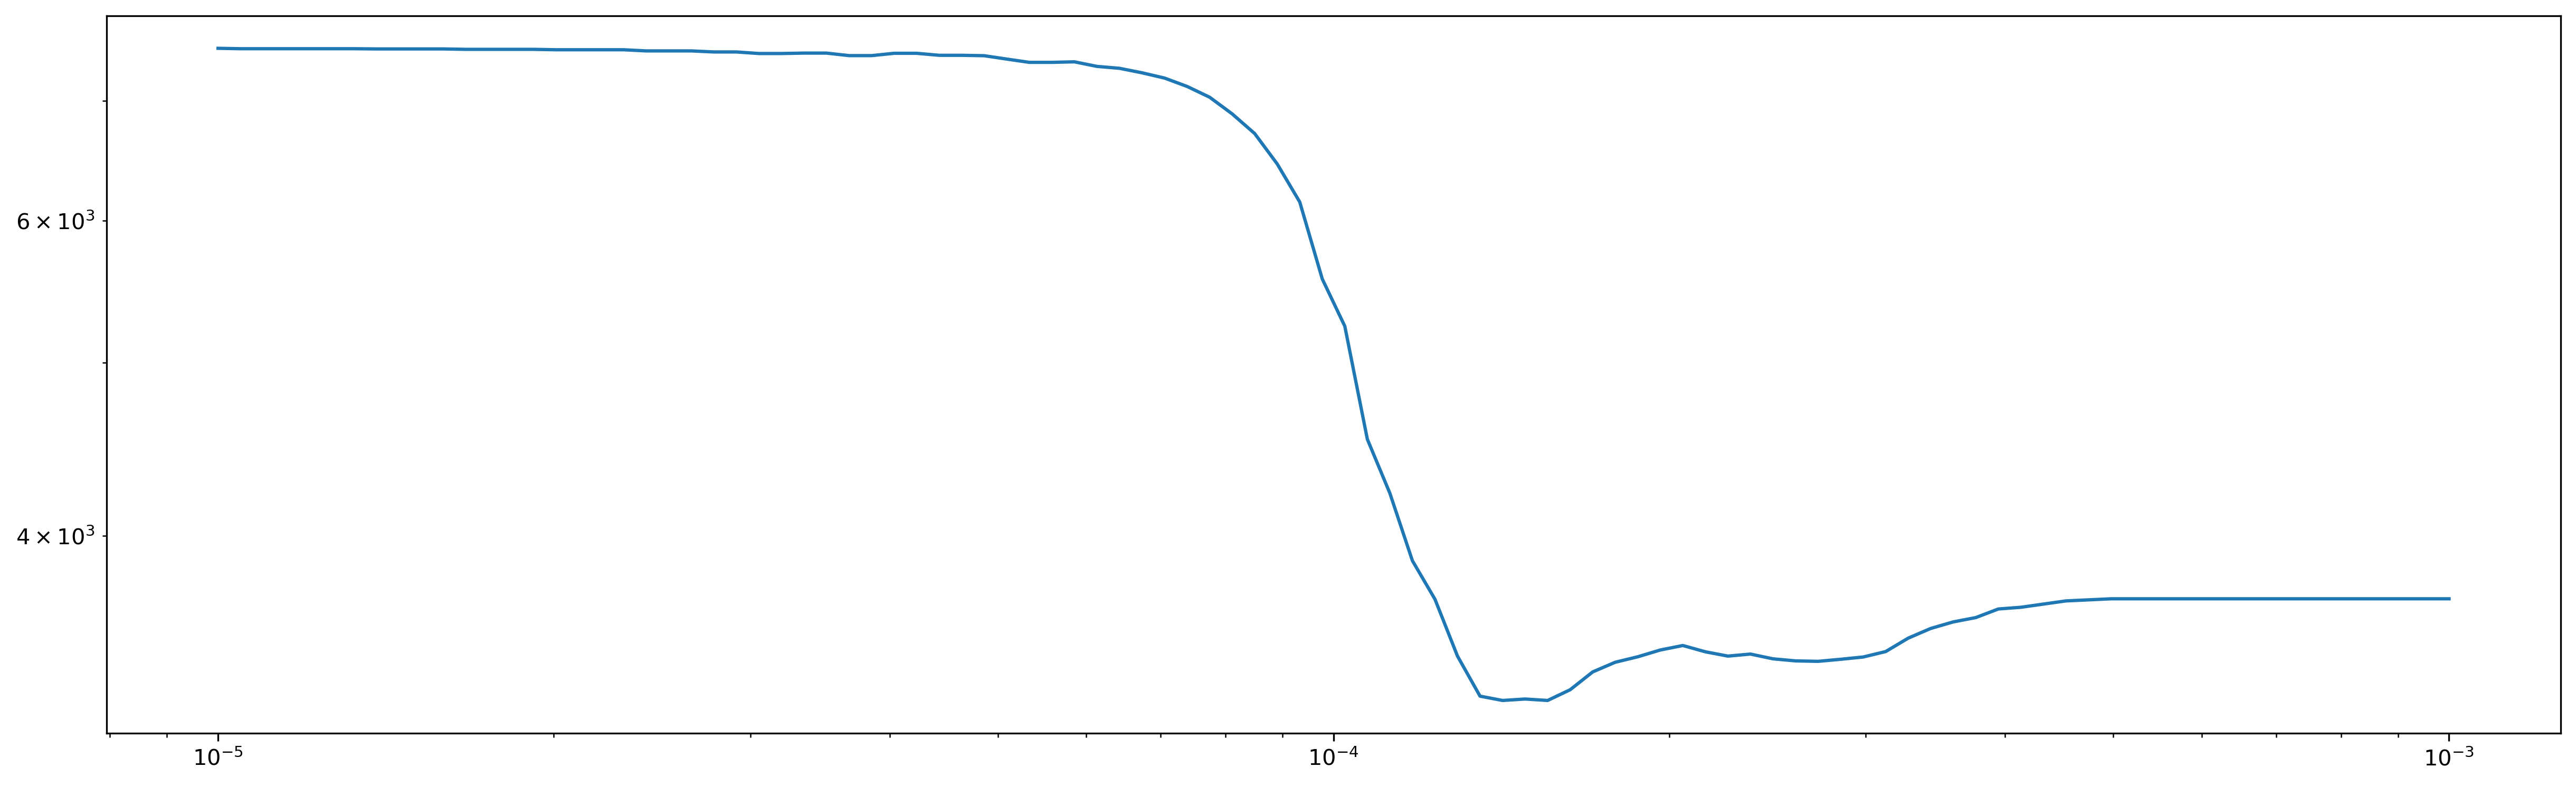

In [179]:
x = np.logspace(-3,-5, 100)
cost_values = [cost_function(threshold, **kwargs) for threshold in tqdm(x)]
plt.plot(x, cost_values)
plt.xscale('log')
plt.yscale('log')
x[np.argmin(np.array(cost_values))], min(cost_values)

In [180]:
from scipy.optimize import minimize

In [17]:
min_x_found = minimize(cost_function, 0.0001555676, args=(grid_count_data_dict, label_data_binary_classification)).x
min_x_found

array([0.00015557])

This isnt working properly yet

##### Currently use minimum found by logarithmic grid search

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.50it/s]


Text(0, 0.5, 'cost')

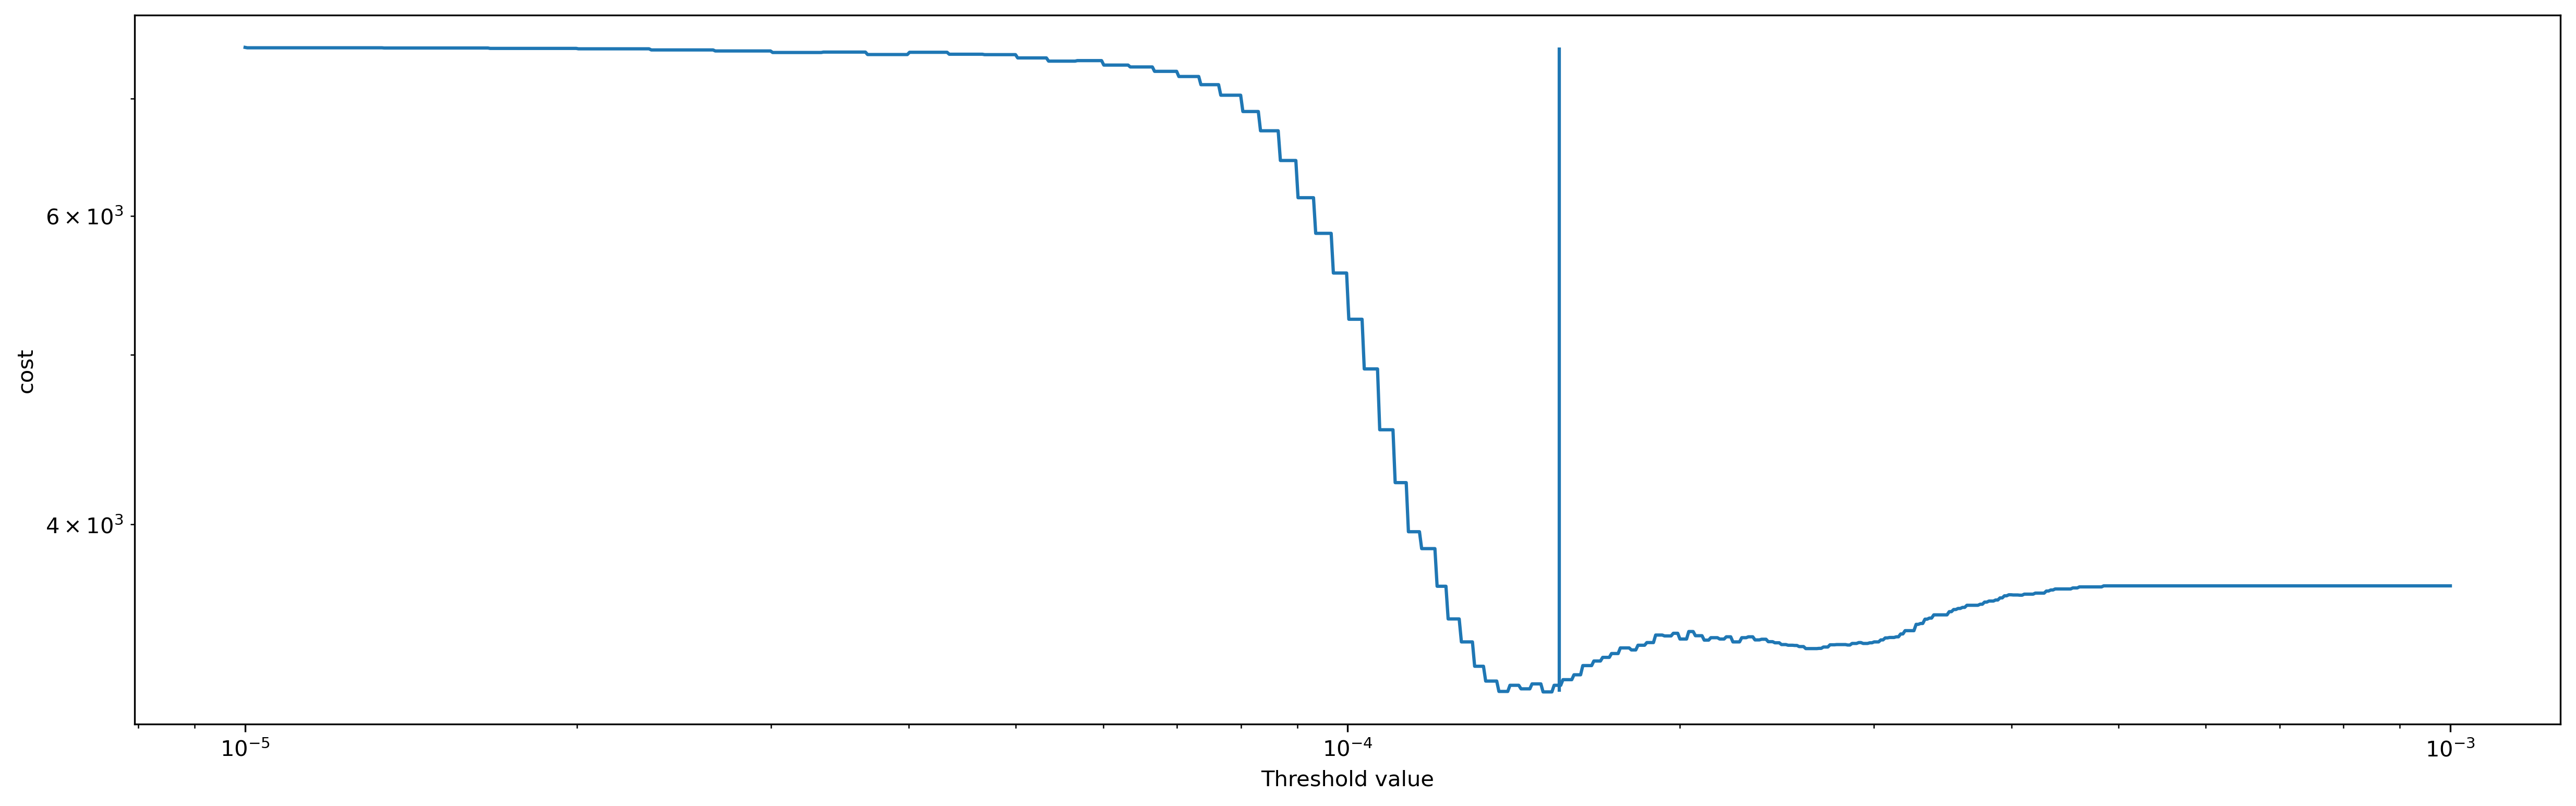

In [185]:
x = np.logspace(-3,-5, 1000)
cost_values = [cost_function(threshold, **kwargs) for threshold in tqdm(x)]
plt.plot(x, cost_values)
plt.xscale('log')
plt.yscale('log')
plt.vlines(0.0001555676, min(cost_values), max(cost_values))
plt.xlabel("Threshold value")
plt.ylabel("cost")

Value chosen for threshold is 0.00015557

### A quick investigation into most efficient method for producing predictions to be used in the training process

In [187]:
def threshold_based_prediction(threshold, grid_count_data_dict):
    return np.array([[filename, "A"] if val >= threshold else [filename, "N"] for filename, val in grid_count_data_dict.items()])

In [199]:
import time

In [200]:
time_1_values = []
time_2_values = []

for i in range(100):
    threshold = 0.00015557
    start_1 = time.time()
    predictions = threshold_based_prediction(threshold, grid_count_data_dict)
    end_1 = time.time()
    time_1 = end_1 - start_1

    start_2 = time.time()
    predictions = produce_predictions_based_on_threshold(threshold, **{"grid_count_data_dict": grid_count_data_dict})
    end_2 = time.time()
    time_2 = end_2 - start_2

    arr_labels = np.array([[filename, label] for filename, label in label_data_binary_classification.items()])
    time_1_values.append(time_1)
    time_2_values.append(time_2)

(0.027602782249450685, 0.011385440826416016)

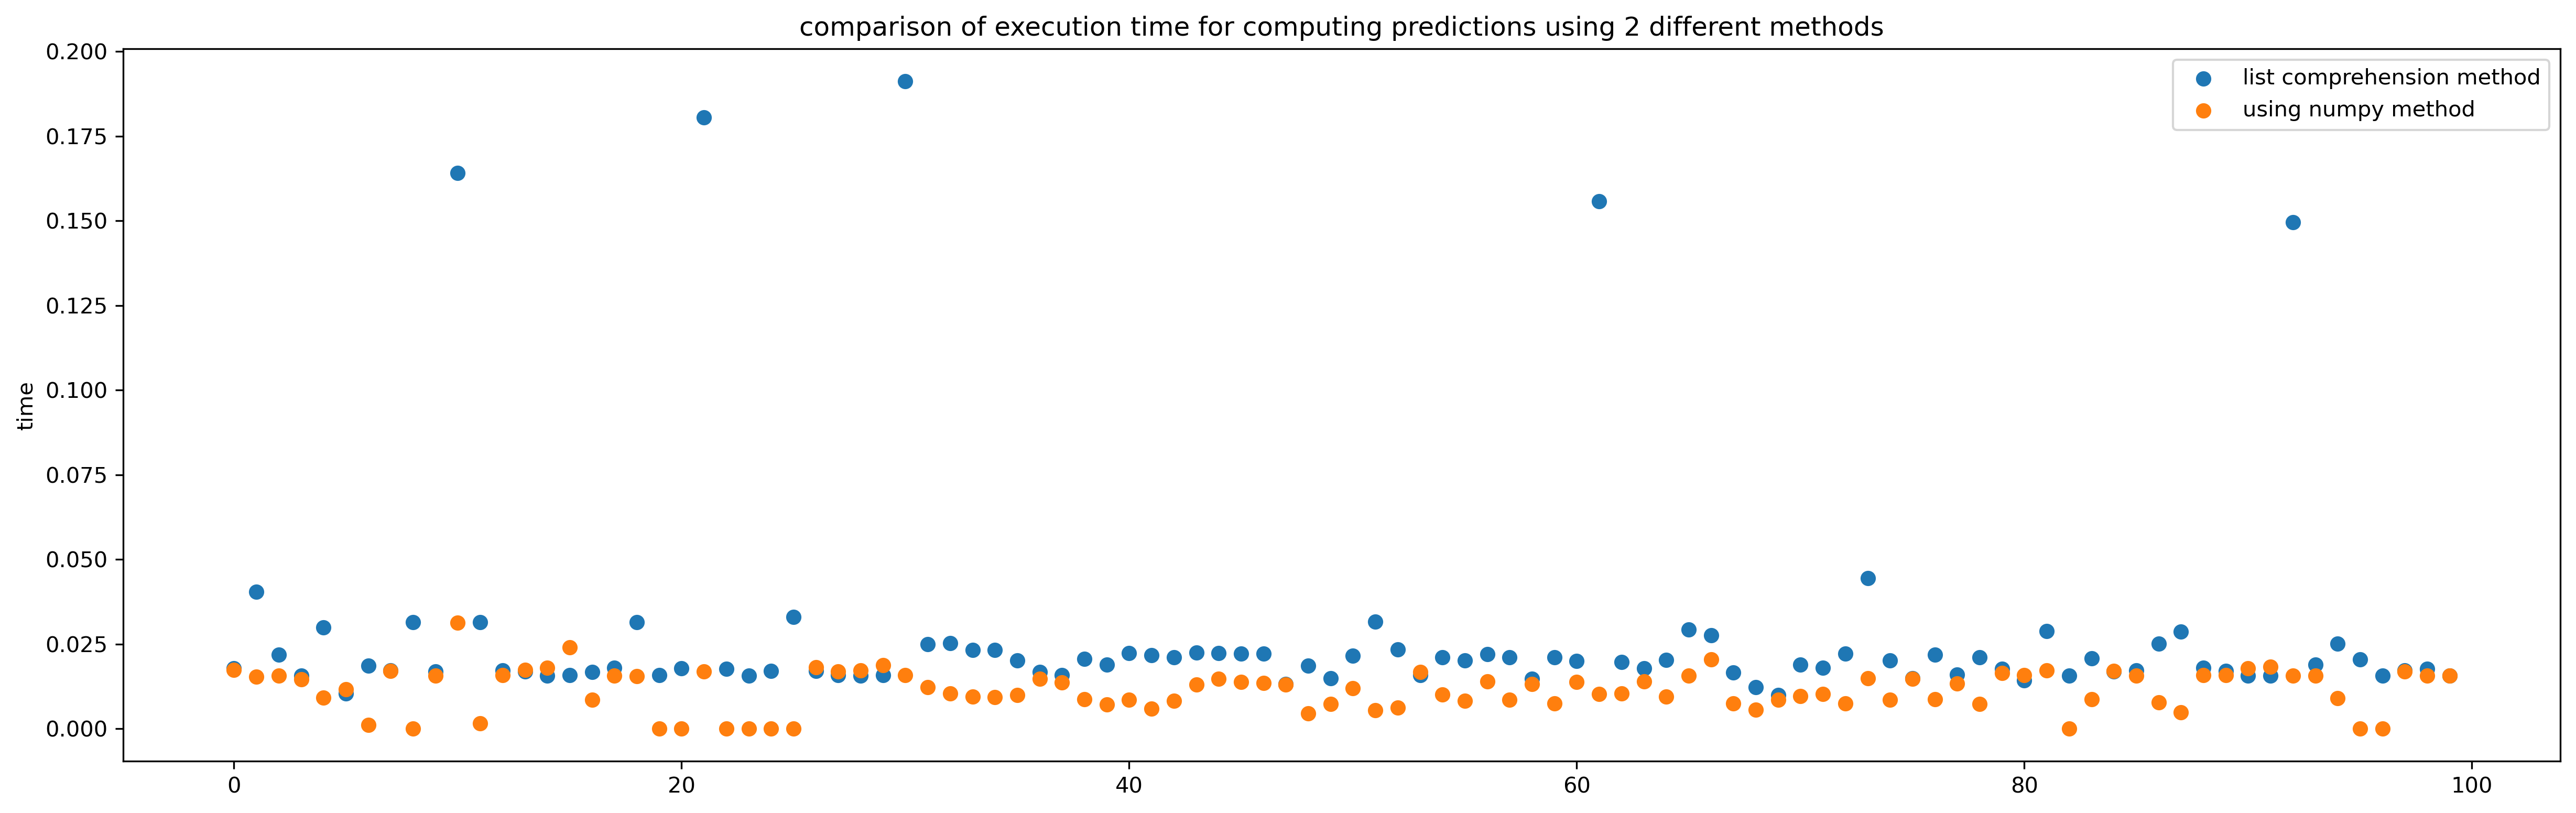

In [203]:
plt.scatter(np.arange(100), time_1_values, label="list comprehension method")
plt.scatter(np.arange(100), time_2_values, label="using numpy method")
plt.title("Comparison of execution time for computing predictions using 2 different methods")
plt.legend()
plt.ylabel("time")
np.mean(np.array(time_1_values)), np.mean(np.array(time_2_values))

Clearly the best method is using numpy extensively, as expected

## Calculate the F1 score for predictions

In [204]:
from utils.performance_metrik import find_f1_score

In [206]:
predictions = produce_predictions_based_on_threshold(threshold, **{"grid_count_data_dict": grid_count_data_dict})
find_f1_score(predictions, arr_labels)

[('A_values:', 0.2842430484037075, 0.37398373983739835, 0.2292358803986711),
 ('N_values:', 0.9044410834593704, 0.8763655742073009, 0.934375)]

Clearly this threshold is not accurate enough for detecting AF, with very low values of F1 score, precision and recall when used. An attempt will now be made to to use this F1 score as the new cost function for optimising this threshold value.

## Optimise threshold by F1 score of AF diagnosis

In [207]:
def f1_score_cost_function(threshold, grid_count_data_dict, label_data):
    predictions_ = produce_predictions_based_on_threshold(threshold, **{"grid_count_data_dict": grid_count_data_dict})
    arr_labels = np.array([[filename, label] for filename, label in label_data.items()])
    f1_scores = find_f1_score(predictions, arr_labels)
    print(f1_scores)
    for diagnosis_score in f1_scores:
        if diagnosis_score[0] == "A_values:":
            return diagnosis_score[1]
        

In [38]:
f1_score_cost_function(0.0005, grid_count_data_dict, label_data_binary_classification)

[('A_values:', 0.2842430484037075, 0.37398373983739835, 0.2292358803986711), ('N_values:', 0.9044410834593704, 0.8763655742073009, 0.934375)]


0.2842430484037075

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


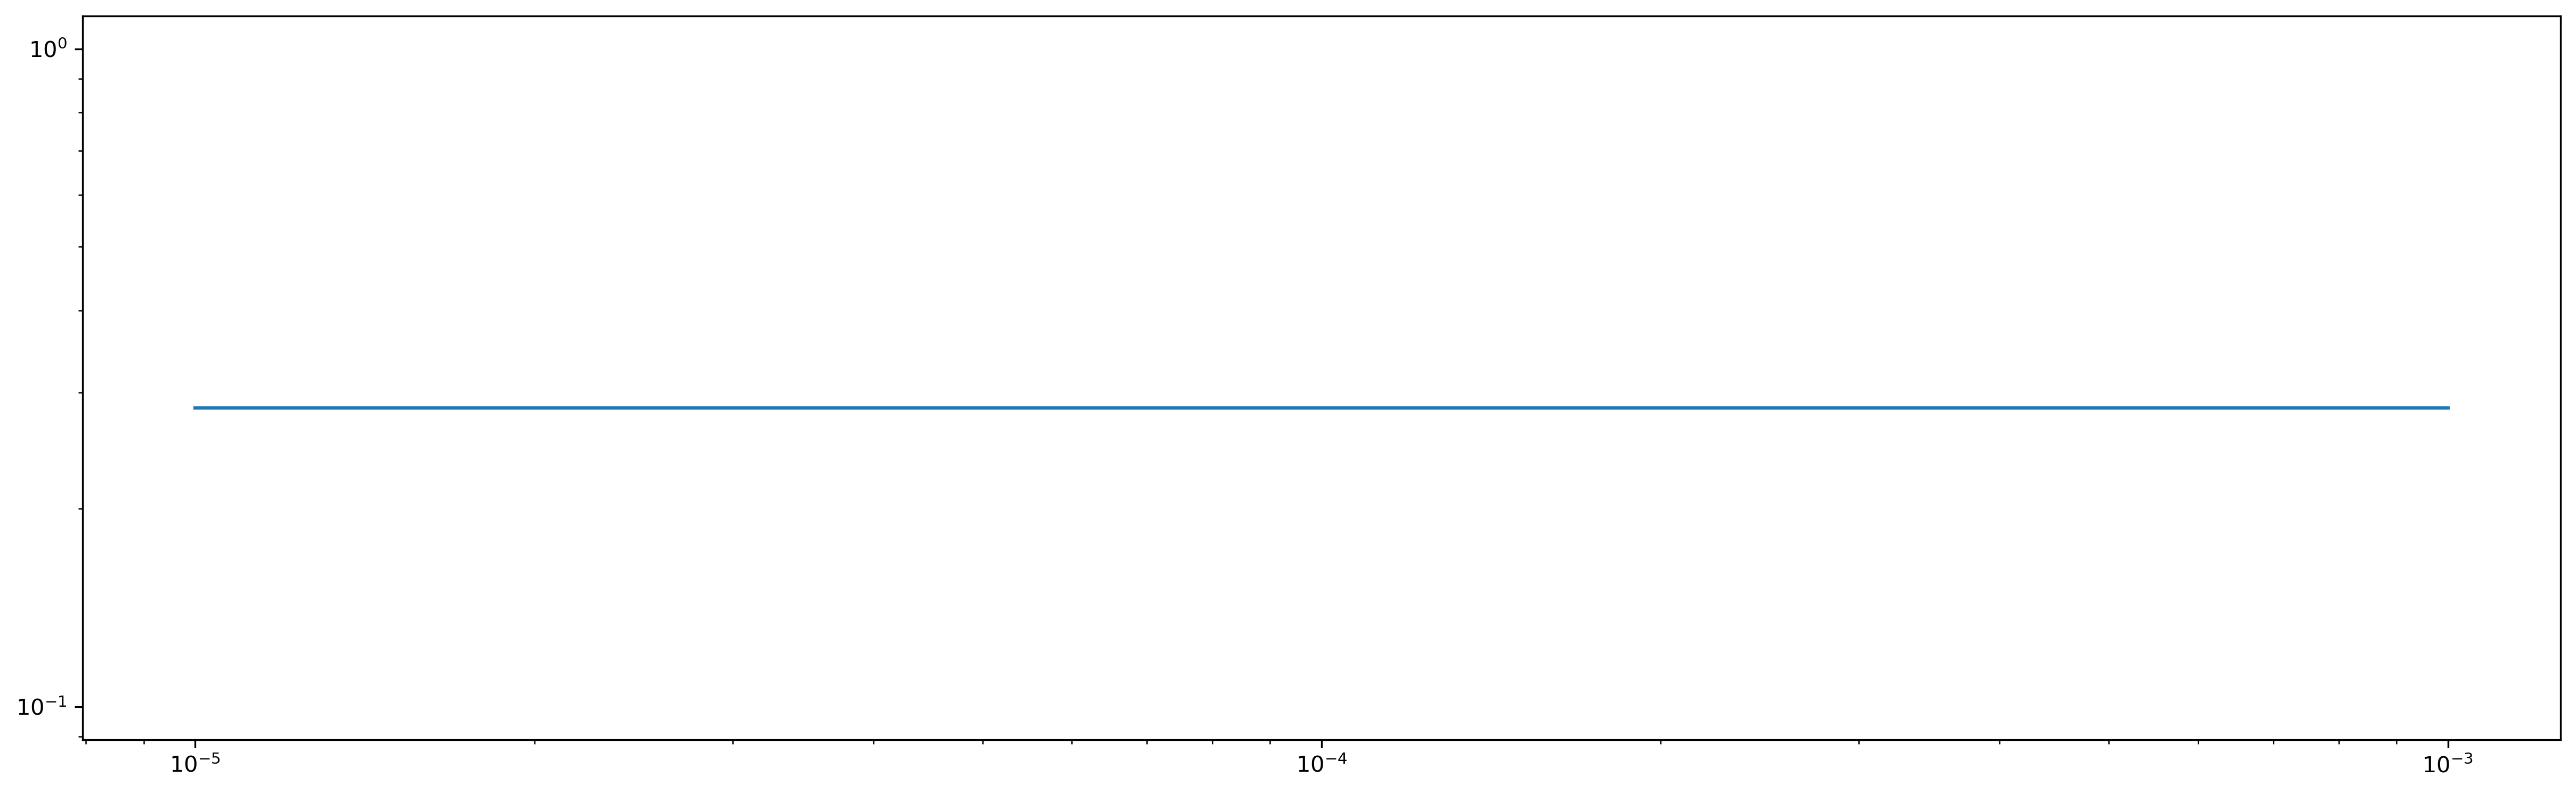

In [36]:
x = np.logspace(-3,-5, 100)
cost_values = [f1_score_cost_function(threshold, grid_count_data_dict, label_data_binary_classification) for threshold in tqdm(x)]
plt.plot(x, cost_values)
plt.xscale('log')
plt.yscale('log')
plt.vlines(min_x_found, min(cost_values), max(cost_values))

In [22]:
threshold = 50
for key, val in spread_data.items():
    if val > threshold:
        ecg_signal = scipy.io.loadmat(f"2_data\\physionet_datasets\\training2017\\{key}.mat")['val'][0]
        # ecg_signal = nk.data(dataset="ecg_3000hz")['ECG'] 
        # ecg_signal += np.random.randn((ecg_signal.size))*0.01
        ecg_signal = ecg_signal / np.max(ecg_signal)
    
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=300)
    
        
        # Visualize R-peaks in ECG signal
        plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)
        plt.title(key)
        
        # Zooming into the first 5 R-peaks
        plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg_signal[:4*300])
        plt.title(key)

NameError: name 'spread_data' is not defined

Taking the spread as the average of the norm values for vectors from each point to the mean point in the data is unable to distinguish between samples of AF or ventricular bigeminy ventricular trigeminy, using a thresholding approach.

Attempt will be made at using the infinite norm of subsample of RR,dRR values from the entire sample, and finding the preportion of them over a certain threshold. 